Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 定義讀取結果的函數
def load_results(result_path, model_name, feature_type, scheme, cost_sensitive=False):
    experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model_name, feature_type, scheme))
    # if not cost_sensitive:
    #     experiment_name += '.no_cs'
    results_path = experiment_name + '.pkl'
    
    with open(results_path, 'rb') as file:
        results = pickle.load(file)
    
    return results, experiment_name

# 定義顯示混淆矩陣列表的函數
def show_cm_list(cm_list, class_names):
    if len(cm_list) == 0:
        raise ValueError("cm_list is empty")
    
    # 確保每個混淆矩陣都是 2D 的
    for cm in cm_list:
        if cm.ndim != 2:
            raise ValueError(f"Confusion matrix in cm_list is not 2D. Shape={cm.shape}")

    avg_cm = np.mean(cm_list, axis=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Average Confusion Matrix')
    plt.show()

# 定義顯示分類報告和準確率的函數
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    class_names_list = list(class_names)  # Convert class_names to a list for index access
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies = {category: 0 for category in class_names}
    summed_accuracy = 0

    for report in rp_list:
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if category in class_names_list and isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value

    for cm in cm_list:
        for i, category in enumerate(class_names_list):
            if category in summed_metrics:  # Ensure category exists in the metrics dictionary
                TP = cm[i, i]
                TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
                summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names_list:
        if category in summed_metrics:
            avg_metrics[category] = {metric: summed_metrics[category][metric] / len(rp_list) for metric in ['precision', 'recall', 'f1-score']}
    
    # Calculate macro and weighted averages
    macro_avg = {metric: sum(avg_metrics[cat][metric] for cat in class_names_list) / len(class_names_list) for metric in ['precision', 'recall', 'f1-score']}
    weighted_avg = {metric: sum(avg_metrics[cat][metric] * summed_category_accuracies[cat] for cat in class_names_list) / sum(summed_category_accuracies.values()) for metric in ['precision', 'recall', 'f1-score']}
    
    # Append macro and weighted averages to avg_metrics
    avg_metrics['macro avg'] = macro_avg
    avg_metrics['weighted avg'] = weighted_avg

    avg_accuracy = summed_accuracy / len(rp_list) if len(rp_list) > 0 else 0
    avg_category_accuracies = {category: summed_category_accuracies[category] / len(cm_list) for category in class_names_list}

    return avg_metrics, avg_category_accuracies, avg_accuracy

Loaded results: {'train_cm_list': [array([[9.29421679e-01, 0.00000000e+00, 1.10607816e-02, 1.71178763e-02,
        4.08195512e-02, 1.58011166e-03],
       [7.59398496e-01, 4.26065163e-02, 1.00250627e-02, 9.02255639e-02,
        8.77192982e-02, 1.00250627e-02],
       [5.60821485e-01, 0.00000000e+00, 1.47551343e-01, 4.48657188e-02,
        2.46129542e-01, 6.31911532e-04],
       [6.83497537e-02, 0.00000000e+00, 1.23152709e-03, 8.47906404e-01,
        7.88177340e-02, 3.69458128e-03],
       [2.74885464e-02, 0.00000000e+00, 8.12161599e-03, 6.95543524e-02,
        8.94002499e-01, 8.32986256e-04],
       [9.23913043e-02, 2.71739130e-03, 5.43478261e-03, 1.46739130e-01,
        2.39130435e-01, 5.13586957e-01]]), array([[9.42799958e-01, 5.26703887e-05, 4.58232382e-03, 1.45370273e-02,
        3.70272833e-02, 1.00073739e-03],
       [7.73869347e-01, 4.77386935e-02, 7.53768844e-03, 8.54271357e-02,
        8.04020101e-02, 5.02512563e-03],
       [5.96336071e-01, 0.00000000e+00, 1.29816804e-01, 4.4

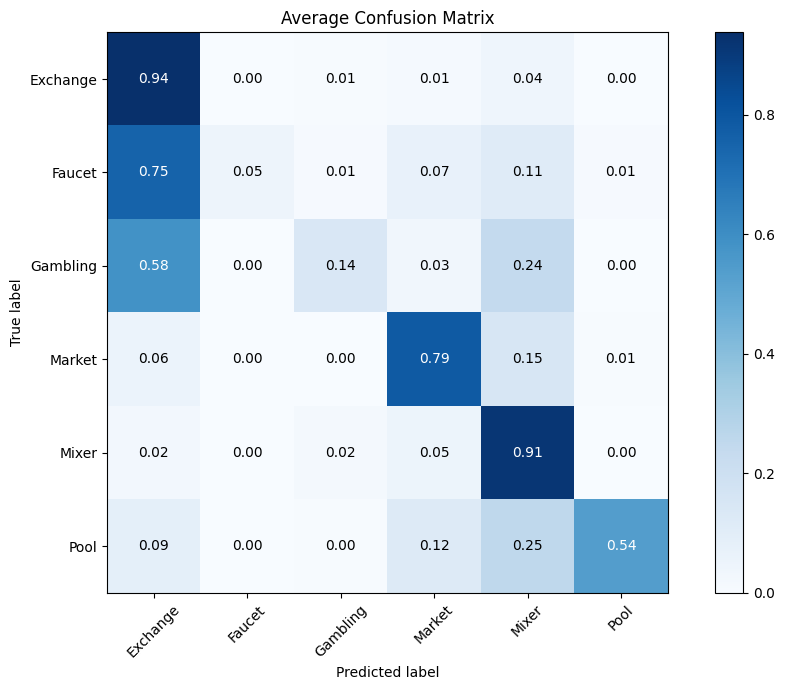

In [2]:
import pickle
import os

# 指定相關參數
result_path = 'result/'  # 替換為你的結果路徑
model_name = 'nn'         # 替換為你的模型名稱
feature_type = 'bem'     # 替換為你的特徵類型
scheme = 'address'       # 替換為你的方案
class_names = ['Exchange', 'Faucet', 'Gambling', 'Market', 'Mixer', 'Pool']  # 替換為你的分類名稱
n_folds = 5  # 替換為你的交叉驗證折數

# 生成檔名
experiment_name = '{}.{}.{}'.format(model_name, feature_type, scheme)
results_file_path = os.path.join(result_path, experiment_name + '.pkl')
model_file_path = os.path.join(result_path, '{}.pkl'.format(experiment_name))

# 載入結果
with open(results_file_path, 'rb') as results_file:
    results = pickle.load(results_file)

# 載入模型
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)

# 打印載入的結果來驗證
print("Loaded results:", results)
print("Loaded model:", model)

# 可以加入繪製圖表的代碼
def plot_confusion_matrices(cm_list, class_names):
    import matplotlib.pyplot as plt
    import numpy as np
    cm_mean = np.mean(cm_list, axis=0)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(cm_mean, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Average Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = cm_mean.max() / 2.
    for i, j in np.ndindex(cm_mean.shape):
        plt.text(j, i, format(cm_mean[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm_mean[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# 使用已載入的訓練混淆矩陣列表繪製平均混淆矩陣
plot_confusion_matrices(results['train_cm_list'], class_names)


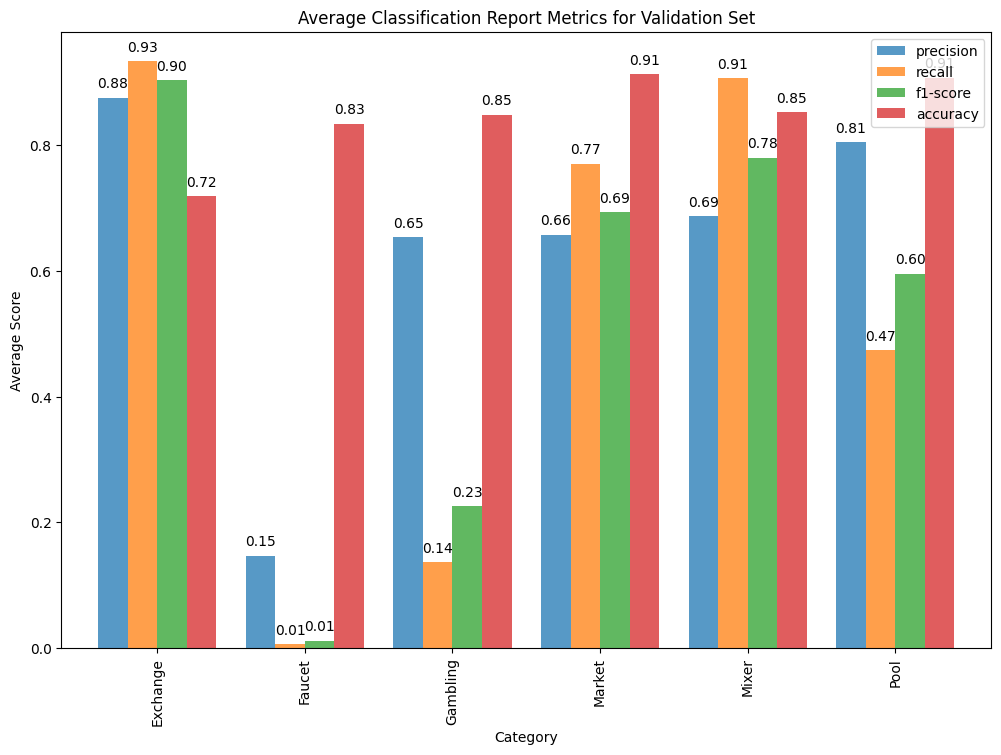

In [3]:
# 定義顯示分類報告和準確率的函數
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    # Initialize dictionaries for summed and average metrics
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies, avg_category_accuracies = {}, {}
    summed_accuracy = 0

    # Initialize summed metrics and accuracies
    for category in class_names:
        summed_metrics[category] = {'precision': 0, 'recall': 0, 'f1-score': 0}
        summed_category_accuracies[category] = 0

    # Iterate over reports and confusion matrices
    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            # Skip 'accuracy', 'macro avg', and 'weighted avg' categories
            if category in ['accuracy', 'macro avg', 'weighted avg']:
                if category == 'accuracy':
                    summed_accuracy += metrics
                continue

            # Sum metrics for each category
            for metric in ['precision', 'recall', 'f1-score']:
                if metric in metrics:
                    summed_metrics[category][metric] += metrics[metric]

        # Calculate and sum category-specific accuracies
        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names:
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in summed_metrics[category].items()}
        avg_category_accuracies[category] = summed_category_accuracies[category] / len(cm_list)
    avg_accuracy = summed_accuracy / len(rp_list)

    # Return average metrics and accuracies
    return avg_metrics, avg_category_accuracies, avg_accuracy

# 使用該函數來計算驗證集的平均分類報告和準確率
avg_metrics, avg_category_accuracies, avg_accuracy = show_rp_list_and_accuracies(results['valid_rp_list'], results['valid_cm_list'], class_names)

# 準備繪製的 DataFrame
df_averages = pd.DataFrame(avg_metrics).T
df_averages['accuracy'] = pd.Series(avg_category_accuracies)

# 繪製條形圖
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics for Validation Set')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# 為每個條形圖添加數值標籤
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [ ]:
# # 定義特徵
# basic = [
#     'f_tx', 'f_received', 'f_coinbase',
#     'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
#     'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
#     'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
#     'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
#     'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
#     'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
# ]
# extra = [
#     'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
#     'total_spent_btc', 'total_received_btc',
#     'total_spent_usd', 'total_received_usd',
#     'mean_balance_btc', 'std_balance_btc',
#     'mean_balance_usd', 'std_balance_usd'
# ]
# moments = [
#     'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
#     'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
#     'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
#     'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
#     'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
#     'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
# ]
# patterns =[
#     'tx_input', 'tx_output',
#     'n_multi_in', 'n_multi_out', 'n_multi_in_out'
# ]

# features = []
# if not feature_type.startswith('if') and len(feature_type) > 0:
#     if 'b' in feature_type:
#         features += basic
#     if 'e' in feature_type:
#         features += extra
#     if 'm' in feature_type:
#         features += moments
#     if 'p' in feature_type:
#         features += patterns
# elif feature_type.startswith('if') and feature_type[2:].isdigit():
#     all_features = basic + extra + moments + patterns
#     if_indices = [
#         0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
#         1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
#         39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
#         16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
#         4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
#         3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
#         51, 50, 22, 12
#     ]
#     if_features = [all_features[i] for i in if_indices]
#     n_if = int(feature_type[2:])
#     features = if_features[:n_if]
# else:
#     raise Exception('Invalid feature types: {:s}'.format(feature_type))


# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # 確保有特徵重要性數據
# if len(results['fi_list']) == 0:
#     raise ValueError("No feature importance data found.")

# # 計算平均特徵重要性
# fi_avg = np.mean(results['fi_list'], axis=0)

# # 打印特徵重要性的排序
# print(fi_avg.argsort()[::-1])

# # 準備特徵重要性數據的 DataFrame
# df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})

# # 選取前10個重要特徵
# df_top_10 = df_feature_importances.nlargest(10, columns='importance')

# # 繪製特徵重要性條形圖
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importance', y='name', data=df_top_10)
# plt.title('Top 10 Feature Importances')
# plt.xlabel('Importance')
# plt.ylabel('Feature Name')
# plt.show()


[[9.34058488e-01 4.63486110e-04 7.12072149e-03 1.43683180e-02
  4.14609143e-02 2.52807216e-03]
 [7.97232323e-01 6.04040404e-03 1.20606061e-02 7.02424242e-02
  1.06404040e-01 8.02020202e-03]
 [5.88330843e-01 2.52525253e-04 1.36216463e-01 3.15844922e-02
  2.42351773e-01 1.26390326e-03]
 [7.48768473e-02 0.00000000e+00 1.47783251e-03 7.70935961e-01
  1.39901478e-01 1.28078818e-02]
 [2.51525118e-02 0.00000000e+00 1.69900083e-02 4.88037746e-02
  9.07221343e-01 1.83236192e-03]
 [1.32608696e-01 0.00000000e+00 6.52173913e-03 1.25000000e-01
  2.61956522e-01 4.73913043e-01]]


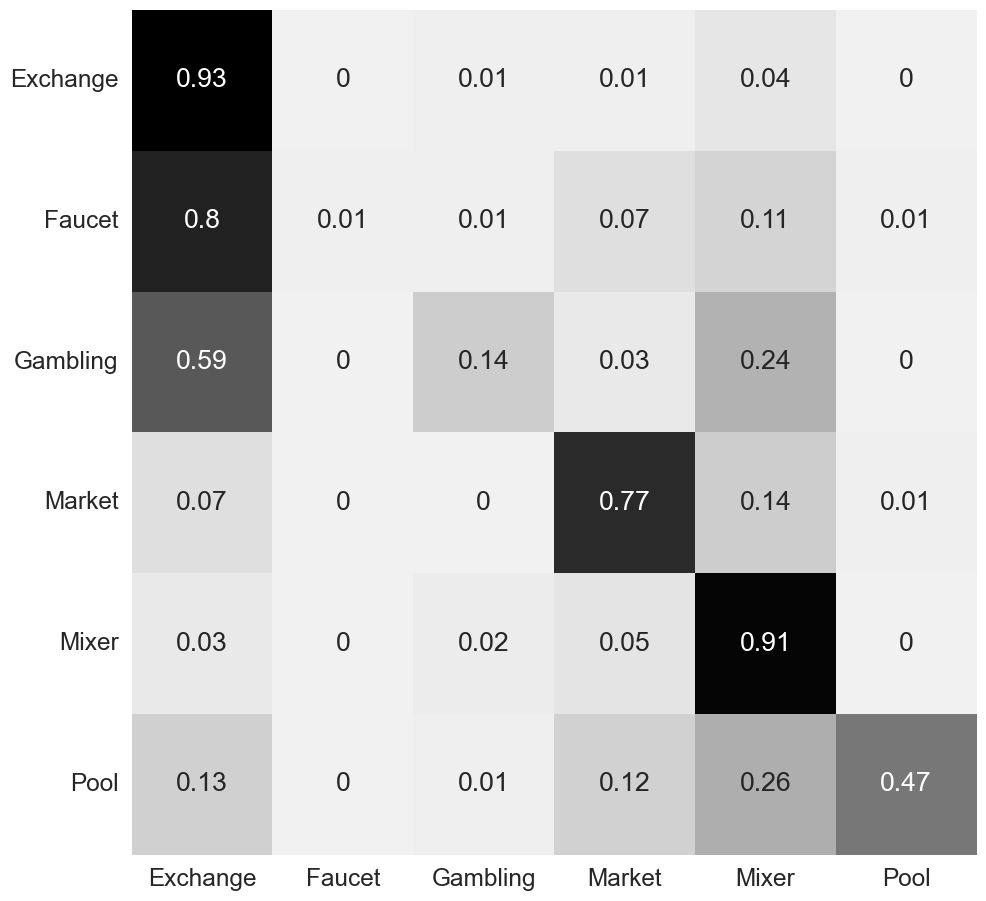

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# 計算驗證集的平均混淆矩陣
cm_avg = np.mean(results['valid_cm_list'], axis=0)

# 打印平均混淆矩陣
print(cm_avg)

# 確保在Jupyter Notebook中運行
def run_from_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False

if run_from_ipython():
    # 準備數據框
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    
    # 設置圖表大小
    plt.figure(figsize=(10, 10))
    
    # 使用輕色調的配色方案
    cmap = sns.light_palette('black', as_cmap=True)
    
    # 設置字體比例
    sns.set(font_scale=1.6)
    
    # 繪製熱力圖
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    
    # 設置x和y軸標籤的旋轉角度
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # 恢復字體比例
    sns.set(font_scale=1)
    
    # 自動調整圖表佈局
    plt.tight_layout()
    
    # 顯示圖表
    plt.show()
    # 保存圖表到文件（如果需要保存，取消下面這行的註釋）
    # plt.savefig('confusion_matrix.png')


Average Training Confusion Matrix:
[[9.37513102e-01 4.21352014e-05 6.96291332e-03 1.25457820e-02
  4.14613294e-02 1.47473760e-03]
 [7.51515724e-01 4.56782660e-02 9.03515069e-03 7.12786993e-02
  1.13457009e-01 9.03515069e-03]
 [5.83648241e-01 0.00000000e+00 1.42342484e-01 3.20953376e-02
  2.41155743e-01 7.58194042e-04]
 [5.61576355e-02 0.00000000e+00 2.09359606e-03 7.86453202e-01
  1.48275862e-01 7.01970443e-03]
 [2.35303009e-02 0.00000000e+00 1.52840057e-02 4.80607055e-02
  9.12333712e-01 7.91276242e-04]
 [8.53260870e-02 5.43478261e-04 4.34782609e-03 1.19293478e-01
  2.54619565e-01 5.35869565e-01]]

Average Validation Confusion Matrix:
[[9.34058488e-01 4.63486110e-04 7.12072149e-03 1.43683180e-02
  4.14609143e-02 2.52807216e-03]
 [7.97232323e-01 6.04040404e-03 1.20606061e-02 7.02424242e-02
  1.06404040e-01 8.02020202e-03]
 [5.88330843e-01 2.52525253e-04 1.36216463e-01 3.15844922e-02
  2.42351773e-01 1.26390326e-03]
 [7.48768473e-02 0.00000000e+00 1.47783251e-03 7.70935961e-01
  1.39901

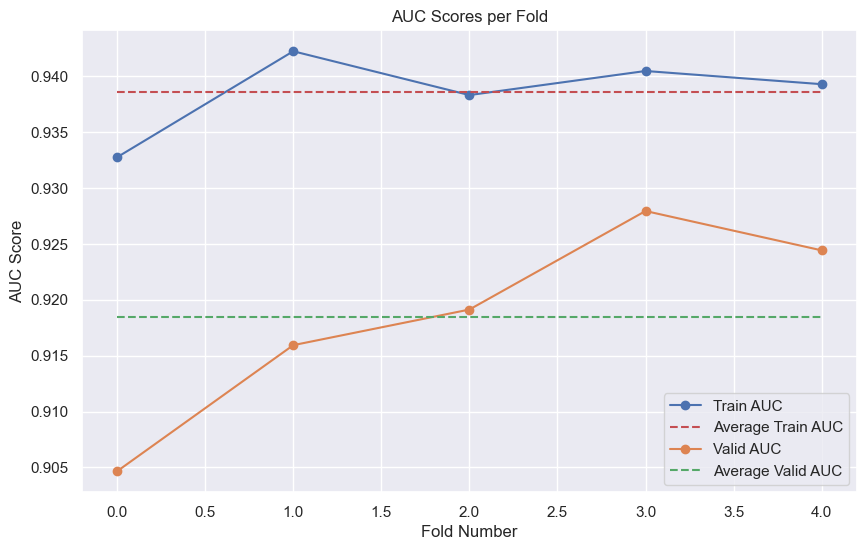

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 確保在前面的程式碼中已經計算了以下變數
# train_cm_list, valid_cm_list, train_auc_list, valid_auc_list

# 計算平均混淆矩陣
avg_train_cm = np.mean(results['train_cm_list'], axis=0)
avg_valid_cm = np.mean(results['valid_cm_list'], axis=0)

# 計算平均AUC分數
avg_train_auc = np.mean(results['train_auc_list'])
avg_valid_auc = np.mean(results['valid_auc_list'])

# 展示平均混淆矩陣
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分數
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 繪製AUC分數圖表
plt.figure(figsize=(10, 6))
plt.plot(results['train_auc_list'], label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(results['train_auc_list']), 'r--', label='Average Train AUC')
plt.plot(results['valid_auc_list'], label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(results['valid_auc_list']), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()


C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_11160\1295774079.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


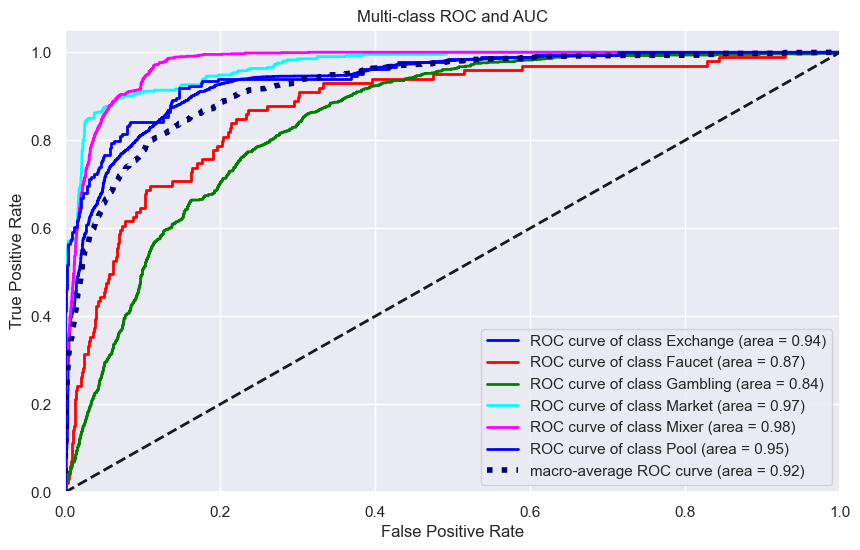

In [6]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# 假設 'class_names' 是一個已定義的列表，包含所有類別的名稱
n_classes = len(class_names)  # 類別的數量

# 使用儲存的 'y_valid' 和 'y_valid_prob'
y_valid = np.array(results['y_valid'])
y_valid_prob = np.array(results['y_valid_prob'])

# 計算每個類別的FPR和TPR
fpr = dict()
tpr = dict()
roc_auc = dict()

# 計算每個類別的ROC曲線和AUC分數
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_valid_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 計算宏觀平均ROC曲線和AUC分數
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 繪製所有類別的ROC曲線
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

# 繪製宏觀平均ROC曲線
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 繪製對角線
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()
